0.689217222442312
0.23436498213046755
end


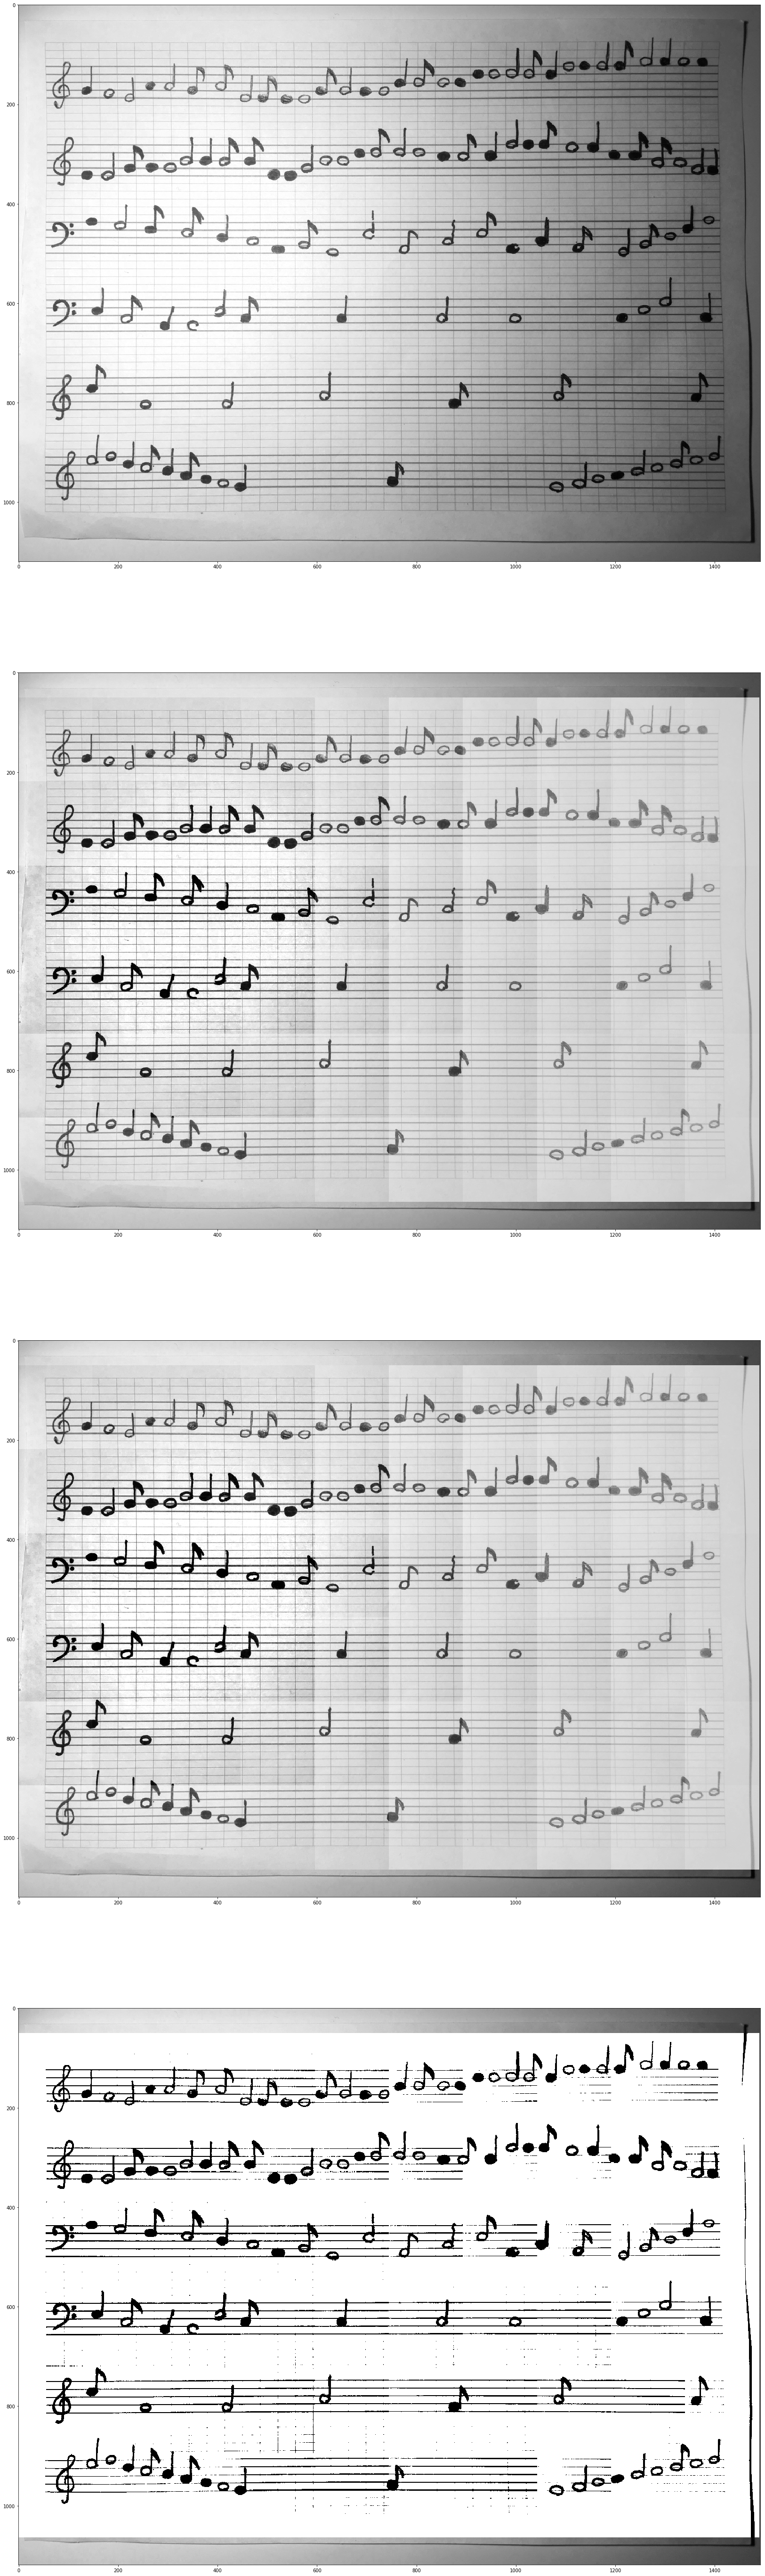

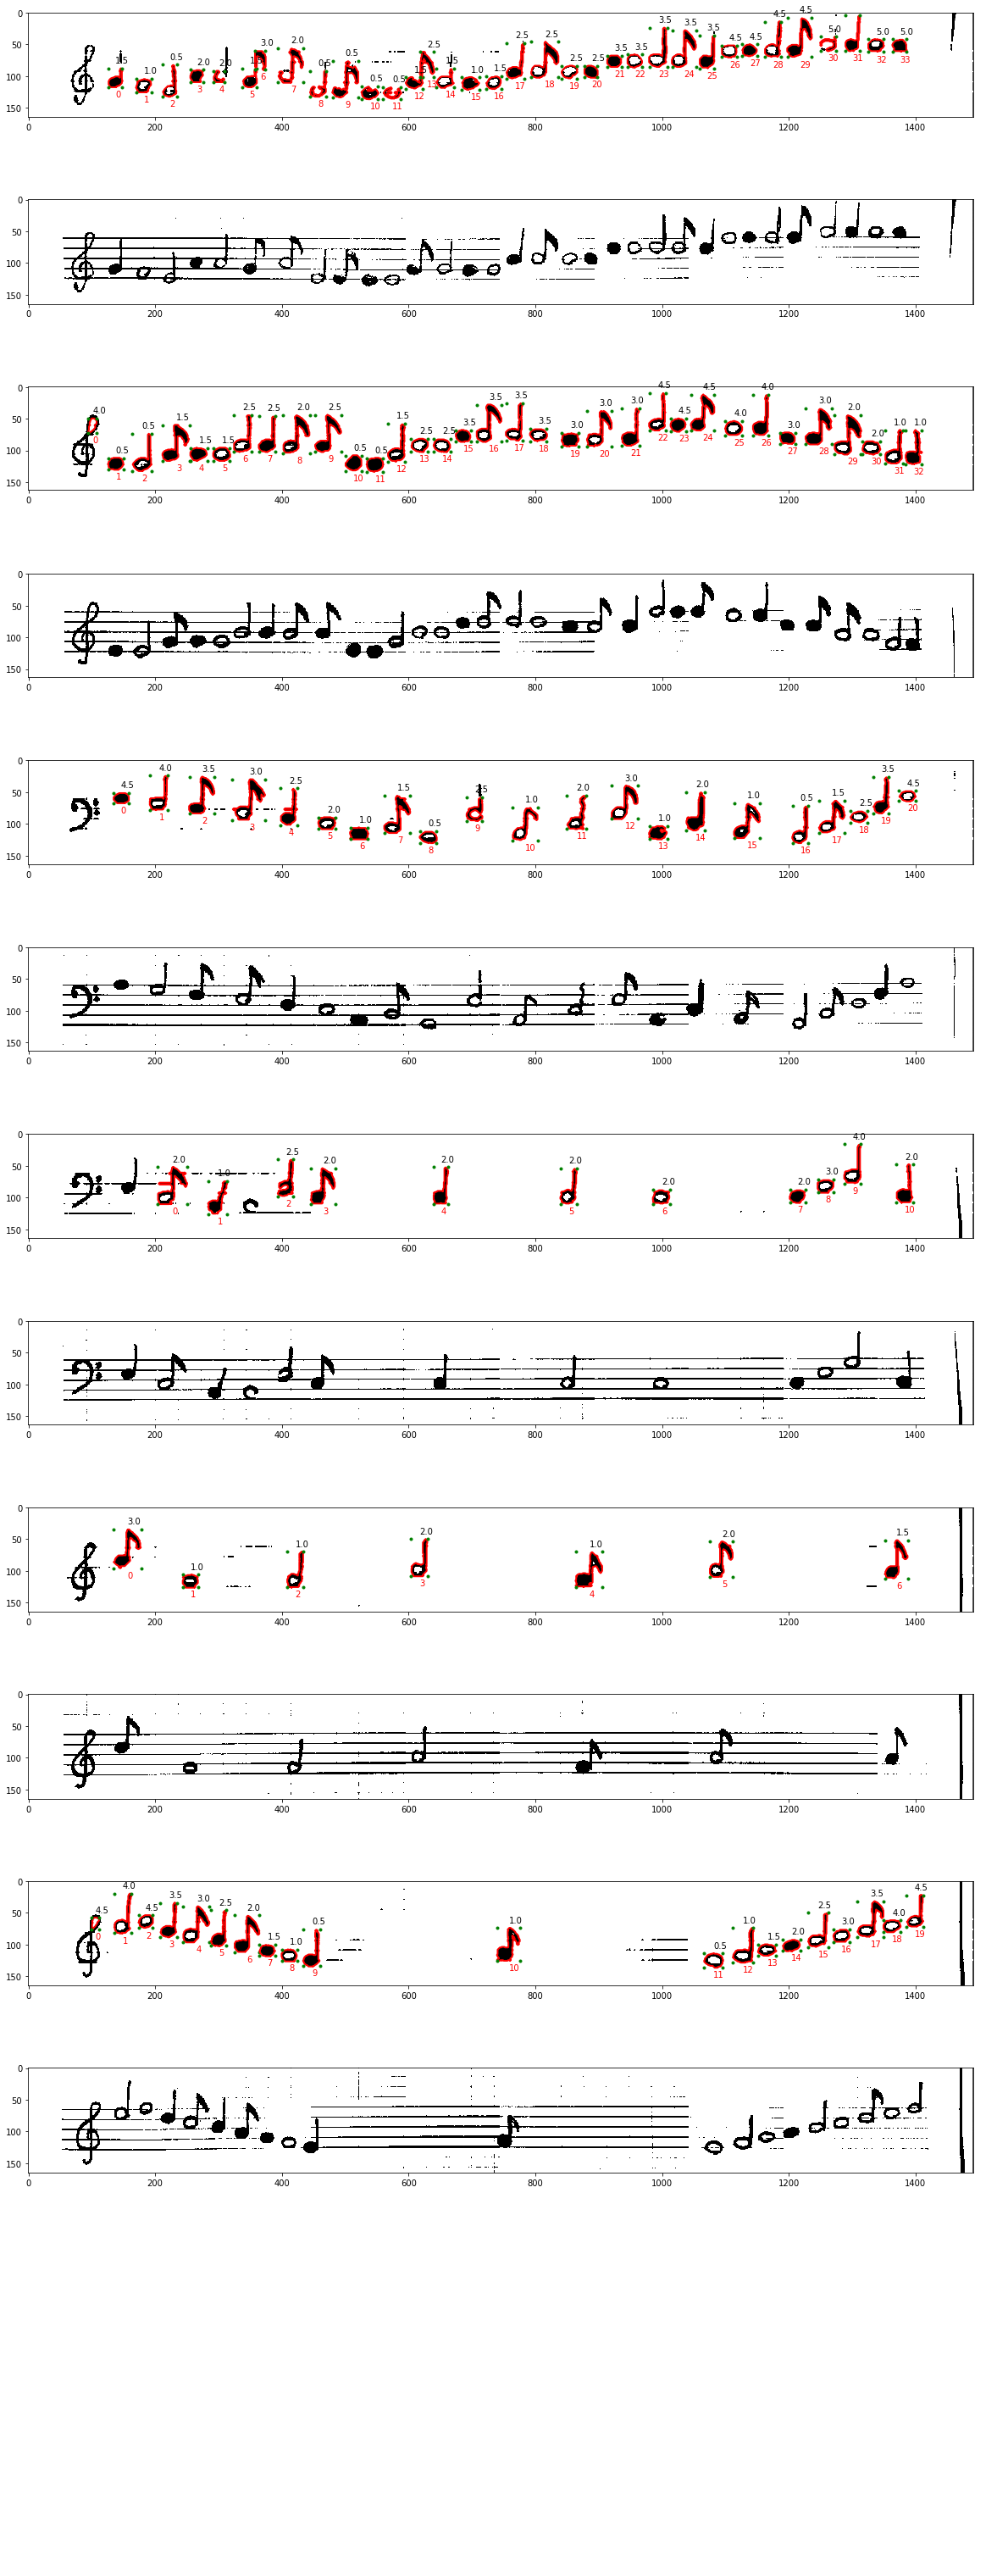

In [56]:
%matplotlib inline 
from __future__ import division
from pylab import *
import skimage as ski
from skimage import data, io, filters, exposure, measure
from skimage.filters import rank
from skimage import img_as_float, img_as_ubyte
from skimage.morphology import disk
import skimage.morphology as mp
from skimage import util
from skimage.color import rgb2hsv, hsv2rgb, rgb2gray
from skimage.filters.edges import convolve
from matplotlib import pylab as plt
import numpy as np
import math
from numpy import array
from IPython.display import display
from ipywidgets import interact, interactive, fixed
from ipywidgets import *
from ipykernel.pylab.backend_inline import flush_figures
from PIL import Image
"""
import sys
sys.path.append('/usr/lib/python2.7/dist-packages')
import shapely
""" 
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

warnings.simplefilter("ignore")

NUM_OF_PARTS_VERTICAL = 6
NUM_OF_PARTS_HORIZONTAL = 10
MARGIN_HORIZONTAL = 20
MARGIN_VERTICAL = 50
    
def szary(img):
    temp = rgb2hsv(img)
    temp[:,:,1] = 0
    return rgb2gray(hsv2rgb(temp))   
    
def gamma(img):
    g = np.mean(img) - 0.3
    return (img**g)

def dynamicGamma(img, mean, std):
    TARGET = (mean*0.9) + (std*0.8)
    diff = TARGET - np.mean(img)
    """0.78**0.48 = 0.88
    0.88**0.58 = 0.93"""
    #print('jasnosc:' + str(np.mean(img)))
    g = math.log(TARGET, np.mean(img))
    #print('potega:' + str(g))
    #print('nowa jasnosc:' + str(np.mean(img**g)))
    return (img**g)
    
def contrast(img):
    MIN = np.percentile(img, 0.3)
    MAX = np.percentile(img, 98)
    norm = (img - MIN) / (MAX - MIN)
    norm[norm[:,:] > 1] = 1
    norm[norm[:,:] < 0] = 0
    return norm

def dynamicContrast(img):
    MIN = np.percentile(img, 0.3)
    MAX = np.percentile(img, 98)
    #MIN = 0.3
    #MAX = 0.9
    norm = (img - MIN) / (MAX - MIN)
    norm[norm[:,:] > 1] = 1
    norm[norm[:,:] < 0] = 0
    return norm

def dynamicThreshold(img):
    #zdj3hd: 0.75
    thr = np.mean(img) - np.std(img) * 1.5
    return (img > thr)

def threshold(img):
    return (img > 0.8)

def dynamicProcessing(img):
    img = szary(img)
    meanGamma = np.mean(img)
    std = np.std(img)
    NUM_OF_PARTS = 5
    partWidth = int(len(img[0])/NUM_OF_PARTS)
    partHeight = int(len(img)/NUM_OF_PARTS)
    for r in range(0,NUM_OF_PARTS):
        for c in range(0,NUM_OF_PARTS):
            row1 = r*partHeight
            col1 = c*partWidth
            row2 = (r+1)*partHeight
            col2 = (c+1)*partWidth
            part = img[row1:row2,col1:col2]
            part = dynamicGamma(part, meanGamma, std)
            part = dynamicGamma(part, meanGamma, std)
            part = dynamicContrast(part)
            img[row1:row2,col1:col2] = dynamicThreshold(part)
    return img

def imageProcessing(img):
    img = szary(img)
    img = gamma(img)
    img = gamma(img)
    img = contrast(img)
    img = threshold(img)
    return img

def removeStaff(img, sumRows):
    height = len(img) - 1
    for i in range(height, 0, -1):
        if sumRows[i]:
            lowest = i + 6
            if (lowest > height): lowest = height
            highest = i - 9
            if (highest < 0): highest = 0
            for c in range(0, len(img[0])):
                remove = True
                for r in range(i+1, lowest):
                    if (img[r][c] == 0):
                        remove = False
                        break
                if remove:
                    for r in range(highest, highest+7):
                        if (img[r][c] == 0):
                            remove = False
                            break
                if remove: img[i][c] = 1
    return img

def locateStaffRows(sumRows):
    staffRows = []
    foundStaff = False
    end = 0
    #search from bottom to top
    for i in range(len(sumRows)-1, 0, -1):
        if sumRows[i]:
            if not foundStaff:
                foundStaff = True
                end = i
        else:
            if foundStaff:
                staffRows.append( ((i+1) + end)/2 )
                foundStaff = False;
    if(len(staffRows) == 5):
        for i in range(1,8,2):
            staffRows.insert( i, ((staffRows[i-1] + staffRows[i]) / 2) )
        staffRows.append( staffRows[8] - (staffRows[7] - staffRows[8]) )
        staffRows.insert( 0, (staffRows[0] + (staffRows[0] - staffRows[1])) )
    return staffRows

def verifyContours(contoursAll):
    #usuniecie za malych konturow (bledy)
    contoursTemp = []
    for contour in contoursAll:
        if(8 < (max(contour[:,0])-min(contour[:,0])) < 70):
            if(10 < (max(contour[:,1])-min(contour[:,1])) < 55):
                contoursTemp.append(contour)
    #posortowanie (numeracja od lewej do prawej na pieciolinii)
    contoursTemp.sort(key=lambda contour: min(contour[:,1]))
    #usuniecie konturow wewnatrz pustych cial nut
    contours = []
    for n, contour in enumerate(contoursTemp[1:]):
        contourPrevious = contoursTemp[n]
        if not ( (min(contour[:,1]) < max(contourPrevious[:,1])) and ( (max(contour[:,1])) < (max(contourPrevious[:,1])) ) ):
            contours.append(contour)
    return contours

#MAIN

##
##  TO DO: Podzial obrazka i obrobka mniejszych fragmentow         #########################################
##

#obróbka zdjęcia
fig, bx = plt.subplots(4, figsize=(30,100))
img = data.imread('zdj4hd.jpg', flatten=False)
#img = imageProcessing(img)
#img = dynamicProcessing(img)
img = szary(img)
bx[0].imshow(img, cmap='gray')
meanGamma = np.mean(img)
std = np.std(img)
print(meanGamma)
print(std)

partWidth = int(len(img[0])/NUM_OF_PARTS_HORIZONTAL)
partHeight = int((len(img)-(MARGIN_VERTICAL*2))/NUM_OF_PARTS_VERTICAL)

"""fig1, cx = plt.subplots(4, figsize=(30,40))
i=0"""
for r in range(0,NUM_OF_PARTS_VERTICAL):
    for c in range(0,NUM_OF_PARTS_HORIZONTAL):
        row1 = (r*partHeight)+50
        col1 = c*partWidth
        row2 = ((r+1)*partHeight)+50
        col2 = (c+1)*partWidth
        part = img[row1:row2,col1:col2]
        part = dynamicGamma(part, meanGamma, std)
        img[row1:row2,col1:col2] = dynamicGamma(part, meanGamma, std)
        """if( (r == 3) and ((c == 1) or (c==9))):
            jasn = np.mean(part)
            stdd = np.std(part)
            mini = np.percentile(part, 0.3)
            maksi = np.percentile(part, 98)
            print(str(r) + ',' + str(c) + ': jasnosc: ' + str(jasn) + ', std: ' + str(stdd))
            print('mini: ' + str(mini) + ', maksi: ' + str(maksi))
            cx[i].imshow(part, cmap='gray')
            i += 1
            cx[i].hist(part, range=(0,1.0))
            i += 1"""
#img = gamma(img)
#img = gamma(img)
bx[1].imshow(img, cmap='gray')
#n, bins, patches = plt.hist(img)
#plt.show()
#img = contrast(img)
img = dynamicContrast(img)
bx[2].imshow(img, cmap='gray')

for r in range(0,NUM_OF_PARTS_VERTICAL):
    for c in range(0,NUM_OF_PARTS_HORIZONTAL):
        row1 = r*partHeight+MARGIN_VERTICAL
        col1 = c*partWidth
        row2 = (r+1)*partHeight+MARGIN_VERTICAL
        col2 = (c+1)*partWidth
        img[row1:row2,col1:col2] = dynamicThreshold(img[row1:row2,col1:col2])
#img = threshold(img)
bx[3].imshow(img, cmap='gray')



#znalezienie linii
sumRows = np.sum(img, axis = 1)
#print(sumRows)
sumRows = (sumRows < (mean(sumRows)*0.8)) #true for row with staff line
sumRowsCpy = sumRows.copy()
img2 = img
#print(sumRowsCpy)

#wydzielenie osobnych fragmentów dla kadej 5-linii
fragmentBounds = []
fragmentFound = False;
rowLen = len(img[0])
start = 0
for n, row in enumerate(sumRows):
    if row:
        if not fragmentFound:
            fragmentFound = True;
            start = n
        #przeszukaj 20 nastepnych wierszy
        foundLine = False;
        for a in range(1,21):
            if (n+a >= len(sumRows)):
                break
            elif sumRows[n+a]:
                foundLine = True
                break
        if foundLine:
            sumRows[n+1] = True;
        else:
            fragmentFound = False;
            if ((n - start) > 60):
                fragmentBounds.append([start,n])

for n, fragment in enumerate(fragmentBounds):
    upper = fragment[0] - 60
    if (upper < MARGIN_VERTICAL):
        upper = MARGIN_VERTICAL
    lower = fragment[1] + 40
    if (lower > len(img)-MARGIN_VERTICAL):
        lower = len(img)-MARGIN_VERTICAL
    fragmentBounds[n] = [upper,lower]

numOfFrags = len(fragmentBounds)
#fig, ax = plt.subplots(numOfFrags*2, 1, figsize=(70,200))
#fig, ax = plt.subplots(5, 1, figsize=(70,120))
fig, ax = plt.subplots(numOfFrags*2, 1, figsize=(20,numOfFrags*2*4))
fragment = [];
""" """
#for i in range(0,numOfFrags-1):
for i in range(0,numOfFrags):
    fragment.append(img[fragmentBounds[i][0]:fragmentBounds[i][1]])
    part = fragment[i]
    partWithStaff = part.copy()
    ax[(i*2)+1].imshow(part, cmap='gray')
    #ax[i+2].imshow(fragment[i], cmap='gray')
    part = mp.dilation(part)
    part = mp.erosion(part)
    part = removeStaff(part, sumRowsCpy[fragmentBounds[i][0]:fragmentBounds[i][1]])
    #print(sumRowsCpy[fragmentBounds[i][0]:fragmentBounds[i][1]])
    part = mp.dilation(part)
    part = mp.erosion(part)
    #part = mp.erosion(part)
    ax[i*2].imshow(part, cmap='gray')
    
    contoursAll = measure.find_contours(part, 0.5)
    contours = verifyContours(contoursAll)
                
    #analize each note
    oldStaffRows = []
    for noteNumber, contour in enumerate(contours):
        #draw contours
        ax[i*2].plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')

        #find rectangle containing note (extreme rows and columns of note contour)
        tm = int(round(min(contour[:,0]))) #topMargin
        bm = int(round(max(contour[:,0]))) #bottomMargin
        lm = int(round(min(contour[:,1]))) #leftMargin
        rm = int(round(max(contour[:,1]))) #rightMargin
        polygon = Polygon(contour)

        #calculate fill ratio of note
        black = 0
        white = 0
        for r in range(tm, bm + 1):
            for c in range(lm, rm + 1):
                if (polygon.contains(Point(r,c))):
                    if (part[r,c] == 1):
                        white += 1
                    else:
                        black += 1
        #fillRatio = black/(black + white)

        #find staff lines and position of note
        beforeNote = partWithStaff[:, lm-6:lm-1]
        sumRowsNote = np.sum(beforeNote, axis = 1)
        sumRowsNote = (sumRowsNote < (mean(sumRowsNote))) #true for row with staff line
        staffRows = locateStaffRows(sumRowsNote)
        if not (len(staffRows) == 11):
            afterNote = partWithStaff[:, rm+1:rm+6]
            sumRowsNote = np.sum(afterNote, axis = 1)
            sumRowsNote = (sumRowsNote < (mean(sumRowsNote)))
            staffRows = locateStaffRows(sumRowsNote)
        if (len(staffRows) == 11):
            oldStaffRows = staffRows.copy()
        else:
            staffRows = oldStaffRows.copy()

## zapisywanie nierozstrzygnietych nut i obliczanie przy najblizszej okazji?
## uwzglednienie topMargin

        #calculate closest line
        closest = 0.5
        current = 0.5
        currentDiff = 0
        if not (len(staffRows) == 0):
            currentDiff = abs(bm - staffRows[0])
        #if (noteNumber < 20): print(str(noteNumber) + ': width:' + str(rm-lm) + ' height: ' + str(bm-tm))
        for staff in staffRows:
            if (abs(bm - staff) < currentDiff):
                currentDiff = abs(bm - staff)
                closest = current
            current += 0.5

        #rectangle corners
        ax[i*2].plot(lm, tm, marker='.', markersize=6, color="green")
        ax[i*2].plot(lm, bm, marker='.', markersize=6, color="green")
        ax[i*2].plot(rm, tm, marker='.', markersize=6, color="green")
        ax[i*2].plot(rm, bm, marker='.', markersize=6, color="green")
        #additional info
        ax[i*2].annotate(noteNumber, xy = ((lm + rm)/2, (bm + 15)), fontsize = 10, color = 'red')
        ax[i*2].annotate(str(closest), xy = ((lm + rm)/2, (tm - 9)), fontsize = 10)
        #ax[(i+1)*2].annotate('fill '+ str(round(fillRatio,2)), xy = ((lm + rm)/2, (tm - 25)), fontsize = 50)
        #ax[4].plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')
        """
        """
print('end')